# Examine a sequence

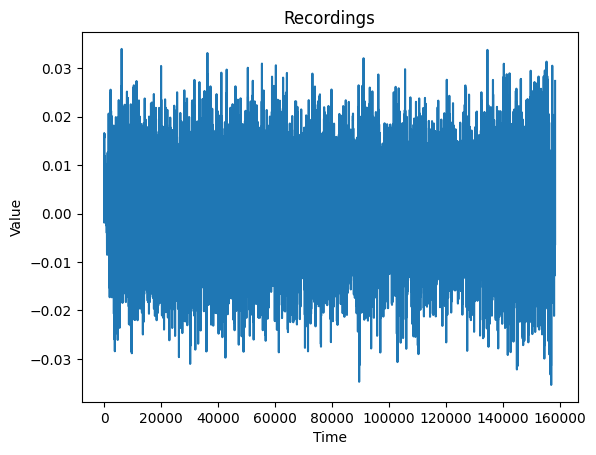

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data from the CSV file
data = pd.read_csv('recordings.csv')

# Plot the data
plt.plot(data)

# Add labels and title
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Recordings')

# Show the plot
plt.show()


# Generate commands

## Use Bash

### Run

```sh
cd src
javac -d ../bin $(find . -name "*.java")
cd ..
java -cp ./bin com.AcousticNFC.Host
```

### Compress

```sh
cd src
javac -d ../bin $(find . -name "*.java")
cd ..
jar cvfm AcousticNFCHost.jar manifest.txt -C bin/ .
```

# Project 1

## Part 2 sound check

In [6]:
# play 1000hz and 10000hz together

from pydub import AudioSegment
from pydub.playback import play
import numpy as np

# Function to generate a tone of particular frequency
def generate_tone(frequency, duration_ms=1000, volume=-30.0):
    # Set sample_rate to the best your mic can offer
    sample_rate = 44100  

    # Generate array
    samples = (np.sin(2*np.pi*np.arange(sample_rate*duration_ms/1000)*frequency/sample_rate))
    # adjust volume
    samples = (samples * (10**(volume/20))*32768).astype(np.int16)

    # Convert to an audio segment
    audio_segment = AudioSegment(
        # raw 16-bit audio
        samples.tobytes(), 
        # 2 bytes (16 bit) sample width
        sample_width=2,
        # 44.1 kHz frame rate
        frame_rate=sample_rate,
        # single channel
        channels=1
    )

    # Decrease the volume 
    audio_segment = audio_segment

    return audio_segment

# Generate the two tones
tone_1000hz = generate_tone(1000)
tone_10000hz = generate_tone(10000)

# Overlay the two tones
combined_tones = tone_1000hz.overlay(tone_10000hz)

# Play combined tone
play(combined_tones)


## The SoF: chirp

### Formulation

The frequency $f(t)$ of a linear chirp signal at any time instance $t$ can be represented as:

$$
f(t) = f_0 + (f_1 - f_0) \cdot \frac{t}{t_1}
$$

Where:
- $f_0$: is the start frequency
- $f_1$: is the end frequency
- $t_1$: is the total duration of the chirp

The phase of a signal is the time integral of its frequency. Thus, the phase $\phi(t)$ of the chirp at any time instance $t$ can be calculated by integrating the above frequency function $f(t)`. The formula for the phase $\phi(t)$ would be:

$$
\phi(t) = 2\pi \int_{0}^{t} f(\tau)d\tau
$$

We can substitute our formula for $f(t)$:

$$
\phi(t) = 2\pi \int_{0}^{t} [f_0 + (f_1 - f_0)\cdot\frac{\tau}{t_1}]d\tau
$$

This integral can be solved by breaking it into two separate integrals:

$$
\phi(t) = 2\pi[f_0 \int_{0}^{t}d\tau + \frac{f_1 - f_0}{t_1}\int_{0}^{t}\tau d\tau]
$$

Finally, substituting these integrals gives us the phase function $\phi(t)$:

$$
\phi(t) = 2\pi[f_0 \cdot t + \frac{f_1 - f_0}{2t_1} \cdot t^2]
$$


### A plot of a chirp

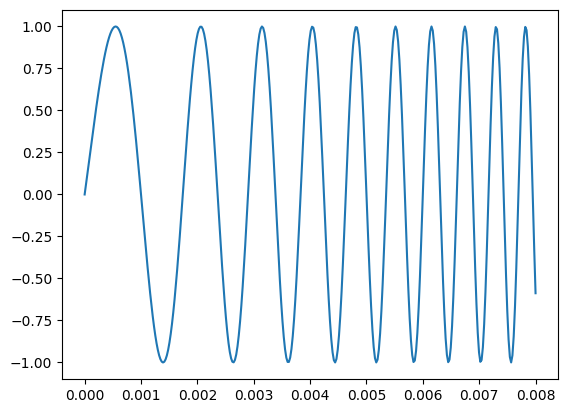

In [38]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
f1 = 400
f2 = 2000
T = 0.008
fs = 44100
t = np.linspace(0, T, (int)(fs * T))
# Generate chirp
y = np.sin(2 * np.pi * (f1 *t + (f2 - f1) / (2 * T) * t**2))
# Display result
plt.plot(t, y)
plt.show()

### Implementation in Dhwani

$$
P(t)= 
\begin{cases} 
      e^{i\pi a t^2} & \text{for } t < T \\
      e^{i [\phi_0 + f_{max}(t−T )−\pi a (t−T )^2]} & \text{for } T < t < 2T 
\end{cases}
$$

where:

$a = \frac{f_{max} - f_{min}}{T}$

$\phi_0 = \pi a T^2$

We take the real part of the above equation (i.e. take cosine) to get the chirp signal.

## Our Bit String

In [1]:
import random

# Choose the length of the bit string
length = 2000

# Generate the random bit string
bit_string = ''.join(str(random.randint(0, 1)) for _ in range(length))

# Write the random bit string into a file
with open('bit_string.txt', 'w') as f:
    f.write(bit_string)

# Print to console
print("Bit string saved to file: bit_string.txt")

Bit string saved to file: bit_string.txt


## Finding the chirp

### Playback the recording

In [30]:
from pydub import AudioSegment
from pydub.playback import play
import numpy as np

# load samples.csv
samples = np.loadtxt('samples.csv')

volume = -10

samples = (samples * (10**(volume/20))*32768).astype(np.int16)

# Set sample_rate to the best your mic can offer
sample_rate = 44100

# Convert to an audio segment
audio_segment = AudioSegment(
    # raw 16-bit audio
    samples.tobytes(), 
    # 2 bytes (16 bit) sample width
    sample_width=2,
    # 44.1 kHz frame rate
    frame_rate=sample_rate,
    # single channel
    channels=1
)

# Play the audio segment
play(audio_segment)

### Plot the correspondence calculated

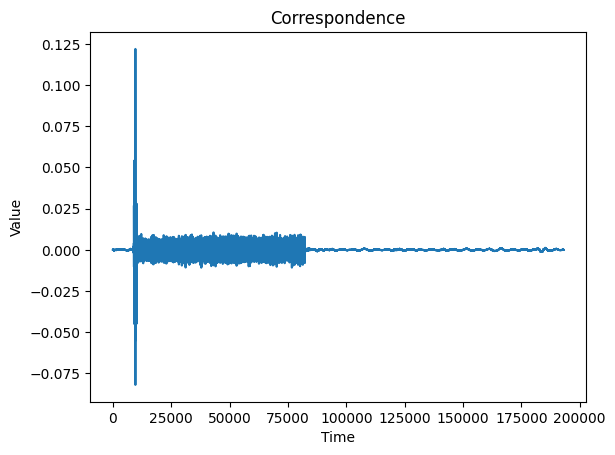

In [52]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data from the CSV file
data = pd.read_csv('correlations.csv', header=None)

# Plot the data
plt.plot(data)

# Add labels and title
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Correspondence')

# Show the plot
plt.show()


In [53]:
# see how many is above 5
import pandas as pd
import matplotlib.pyplot as plt

# Load the data from the CSV file
data = pd.read_csv('correlations.csv', header=None)

threshold = 0.06

print(data[data > threshold].count())
# print the >10 values
print(data[data[0] > threshold])

0    5
dtype: int64
             0
9673  0.094156
9674  0.122012
9675  0.061349
9680  0.088628
9681  0.073213


In [60]:
# calculate the std
print(data.std())

0    0.058644
dtype: float64


### Problems & Solutions

During project1, though not announced yet, I sensed the need to concurrently transmit and receive.

- My first solution is to do the correlation with SoF computation in the BufferSwitch Interrupt.

    - It turns out that the operations in the interrupt are too expensive so that before an interrupt is completed, the next interrupt just comes up and stops everything under excecution.
    
- Then I tried to start another thread to do the computation

    - The new thread was in the beginning always not running because it's a busy `while(true)` to the environment.
    
    - Unconsious, I added `System.out.print()` inside the while, then it suddenly works, but the sound played became laggy. The same happened when I used a lock to protect the shared resource, the buffer of the `Receiver`.

- Finally, I turn to optimize the way to fill in the recording buffers, it was originally allocating a new array and copy everything in, which is too expensive for an interrupt. Now I'm using a dynamic array library containing the type `ArrayList`

In [1]:
print(44100/171)
print(44100/170)
print(44100/172)

257.89473684210526
259.4117647058824
256.3953488372093


## Demodulation

### Spectrum

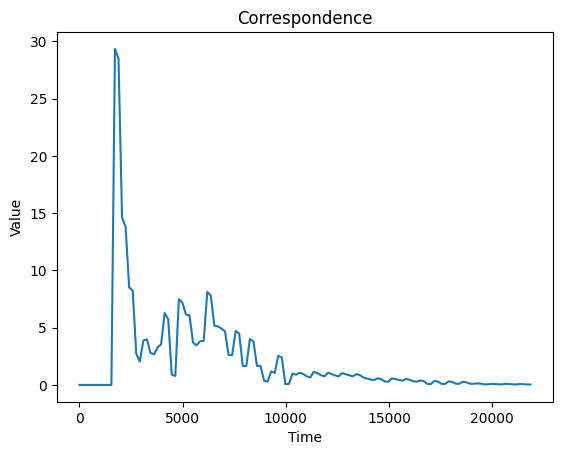

In [57]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the data from the CSV file
data = pd.read_csv('amplitudes.csv', header=None)

data[:10] = 0

subcarrierwidth = 172

# Plot the data
plt.plot(np.arange(0, len(data)*subcarrierwidth, subcarrierwidth), data)

# Add labels and title
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Correspondence')

# Show the plot
plt.show()


In [38]:
import numpy as np

dataNP = np.array(data)
# print freqs with highest amplitude
print(np.argsort(dataNP, axis=0)[-10:])

[[49]
 [48]
 [45]
 [44]
 [41]
 [39]
 [38]
 [40]
 [37]
 [36]]


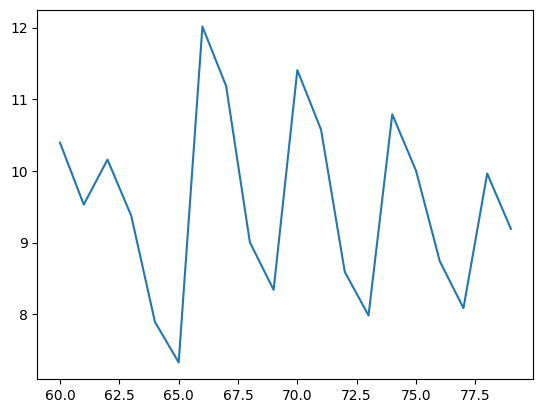

In [42]:
plt.plot(data[60:80])

In [47]:
44100/256*35

6029.296875